In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time
import random
from sklearn import tree
from emukit.quadrature.methods import VanillaBayesianQuadrature
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
import subprocess

In [5]:
num_experiments = 100
parameter_list = ['gamma', 'gradnoise']
#parameter_list =  ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']
parameter_space = ParameterSpace([
                                DiscreteParameter('gamma',list(range(0,25))),
                                ContinuousParameter('gradnoise',0.25,0.99)])
"""parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])"""

In [6]:
file_names = ["gradient_latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["gradient_latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [ ]:
# file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
# data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [7]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files) 
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [8]:
all_data = [read_data(file_name) for i,file_name in enumerate(data_files) if i not in unrun_files]

In [9]:
def plot(num,func):
    all_times = sorted(set([i.time for i in all_data[num]]))
        
    x = []
    y = []
    
    for i in all_times:
        x.append(i)
        y.append(func(all_data[num],i))
        
    plt.plot(x,y)
    

In [10]:
Y = get_rewards(data_files,lambda s: len(s))

In [11]:
run_to_completion = Y>5000

In [12]:
X_full, Y_full = X[run_to_completion.flatten(),:], Y[run_to_completion.flatten()]

In [13]:
X_full[0,:] = np.lcm(X_full[0,:].astype(int),25)

In [14]:
data_full = [data for i,data in enumerate(all_data) if run_to_completion[i,0] == True]

In [15]:
num_blob_data = [[num_blobs_cells(data,j) for j in range(0,50000,1000)] for data in data_full]

In [16]:
num_blob_data = np.array(num_blob_data)

In [17]:
num_blob_data.shape

(88, 50)

# 1. Decision Tree; what are the most important values

In [18]:
X_tree = X_full
Y_tree = num_blob_data[:,0].reshape(len(num_blob_data),1)

In [19]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree)

DecisionTreeClassifier()

In [20]:
clf.feature_importances_

array([0.68959152, 0.31040848])

In [21]:
Y_tree_rounded = np.digitize(Y_tree,[0,20,100])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

[Text(401.76000000000005, 543.6, 'X[0] <= 5.5\ngini = 0.261\nsamples = 88\nvalue = [4, 9, 75]'),
 Text(267.84000000000003, 326.16, 'X[0] <= 4.5\ngini = 0.426\nsamples = 13\nvalue = [4, 9, 0]'),
 Text(133.92000000000002, 108.72000000000003, 'gini = 0.0\nsamples = 9\nvalue = [0, 9, 0]'),
 Text(401.76000000000005, 108.72000000000003, 'gini = 0.0\nsamples = 4\nvalue = [4, 0, 0]'),
 Text(535.6800000000001, 326.16, 'gini = 0.0\nsamples = 75\nvalue = [0, 0, 75]')]

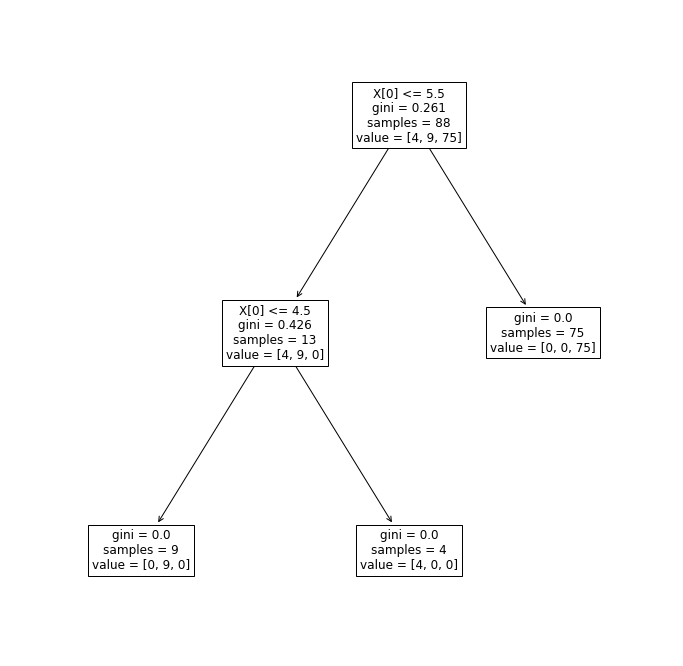

In [22]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

In [23]:
Y_tree = num_blob_data[:,-1].reshape(len(num_blob_data),1)
Y_tree_rounded = np.digitize(Y_tree,[50])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

In [24]:
clf.feature_importances_

array([0.94652778, 0.05347222])

[Text(401.76000000000005, 570.7800000000001, 'X[0] <= 4.5\ngini = 0.165\nsamples = 88\nvalue = [8, 80]'),
 Text(267.84000000000003, 407.70000000000005, 'X[1] <= 0.668\ngini = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(133.92000000000002, 244.62, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(401.76000000000005, 244.62, 'X[0] <= 3.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(267.84000000000003, 81.53999999999996, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(535.6800000000001, 81.53999999999996, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(535.6800000000001, 407.70000000000005, 'gini = 0.0\nsamples = 79\nvalue = [0, 79]')]

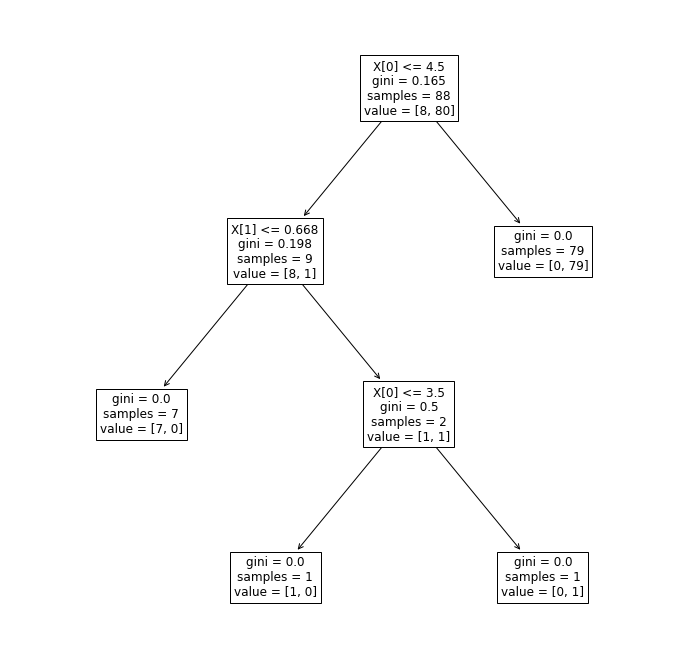

In [25]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

Initial multicellularity is largely based on cell-based parameters, particularly the gamma parameter, and the cell size, both of which dictate how close together they initial huddle together. However, after time persists, the dominant factors in how multicellularity persists are the environmental factors. Temperature is the top factor in the decision tree; if the temperature is large, then particles are too "jumpy" to stick together, and so large temperature lead to large numbers of blobs. Cell factors still play a role, such as having a large enough cell size to encourage contact, and a large enough mutation rate that adhesion is encouraged

# 2. Identify correlations between initial and final multicellularity

In [26]:
Y_initial = num_blob_data[:,0].reshape(len(num_blob_data))
Y_final = num_blob_data[:,-1].reshape(len(num_blob_data))

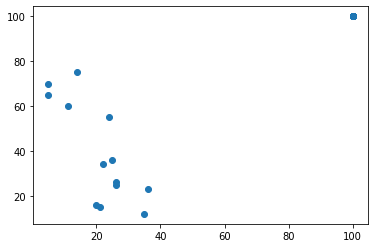

In [27]:
plt.scatter(Y_initial,Y_final)

In [28]:
np.corrcoef(Y_initial,Y_final)

array([[1.        , 0.88872338],
       [0.88872338, 1.        ]])

(array([ 4.,  3.,  4.,  2.,  0.,  0.,  0.,  0.,  0., 75.]),
 array([  5. ,  14.5,  24. ,  33.5,  43. ,  52.5,  62. ,  71.5,  81. ,
         90.5, 100. ]),
 <BarContainer object of 10 artists>)

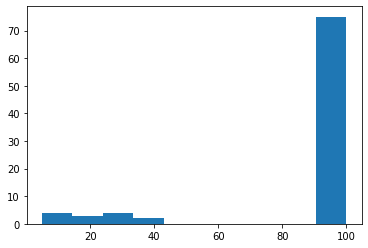

In [29]:
plt.hist(Y_initial)

(0.0, 60.0)

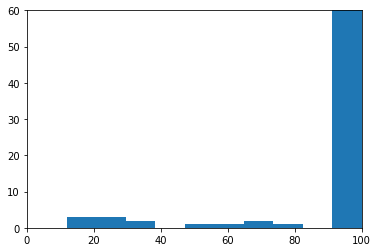

In [30]:
plt.hist(Y_final)
plt.xlim([0,100])
plt.ylim([0,60])

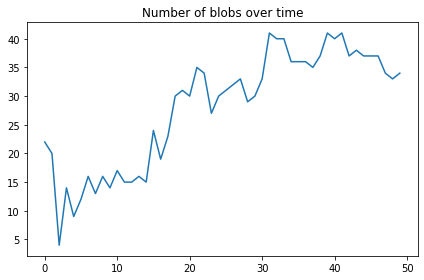

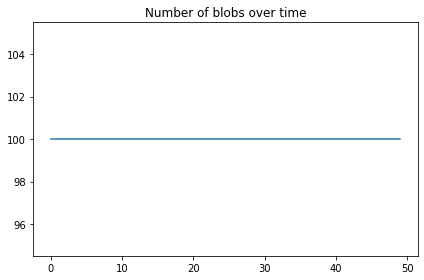

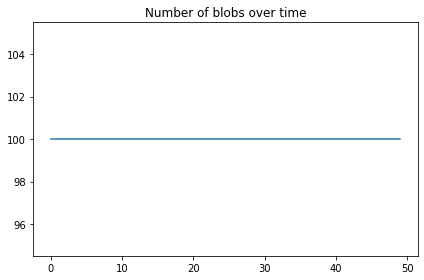

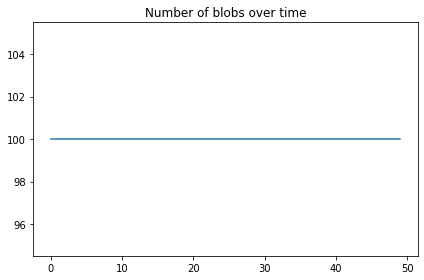

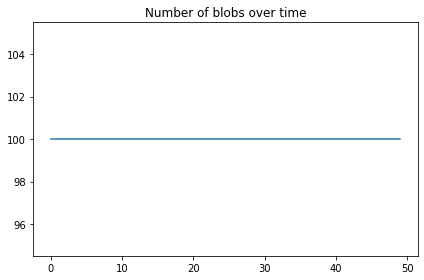

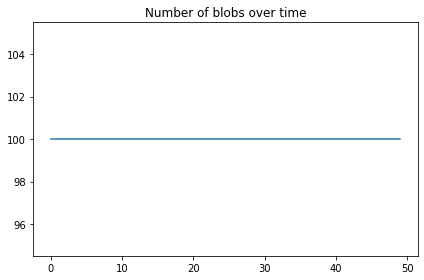

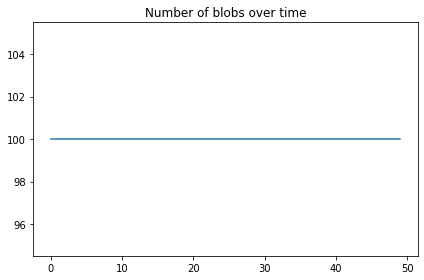

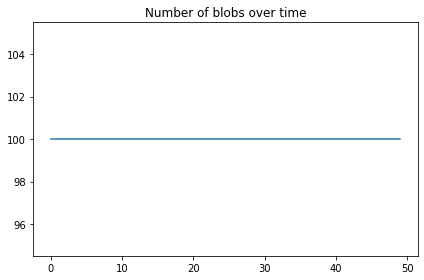

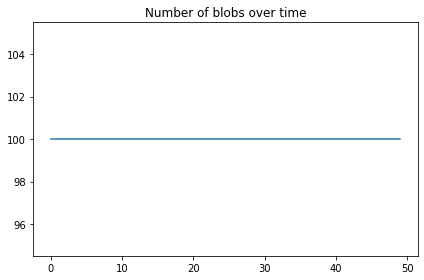

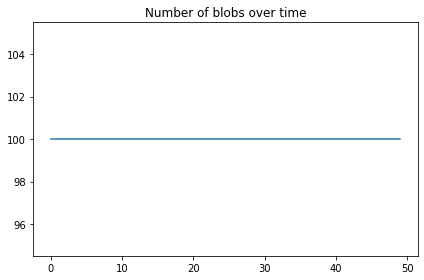

<Figure size 432x288 with 0 Axes>

In [31]:
for i in range(10):
    plt.title("Number of blobs over time")
    index = random.randint(0,len(num_blob_data)-1)
    plt.plot(list(range(len(num_blob_data[index]))),num_blob_data[index])
    plt.tight_layout()
    plt.figure()

We see that initial settings are not soley responsible for the propogation of multicellularity. For different simulations which start with 100 blobs (all cells indepdent), we see that, depending on the celllar and environmental conditions, they tend to break off into different strata. Some simulations start with a sharp increase in multicellularity, followed by a levelling off, while others tend to remain unicellular throughout. In general, many simulations tend towards a degree of multicellularity, which is seen through the two histograms

# 3. Train a GP to predict final multicellularity on Latin Gradient Data

In [32]:
kernel = GPy.kern.RBF(input_dim=X.shape[-1])
model_gpy = GPRegression(X_full, Y_final.reshape((len(Y_final),1)) ,kernel=kernel)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

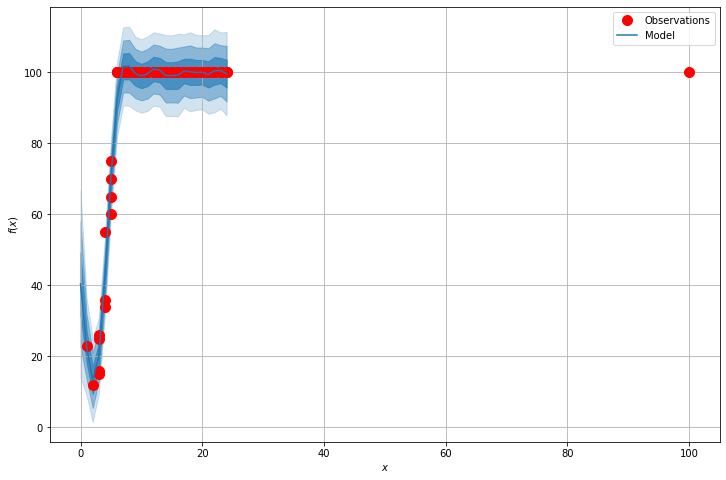

In [35]:
plot_gaussian_process(np.linspace(0,24,25),0,parameter_space,model_emukit)

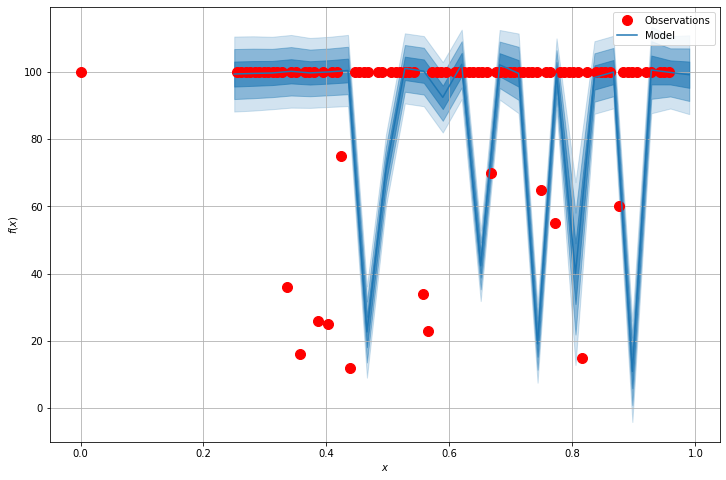

In [36]:
plot_gaussian_process(np.linspace(0.25,0.99,25),1,parameter_space,model_emukit)

Text(0.5, 0.92, 'Predicted angle difference between chemotaxis vector and ground truth gradient position based on gamma and gradient noise')

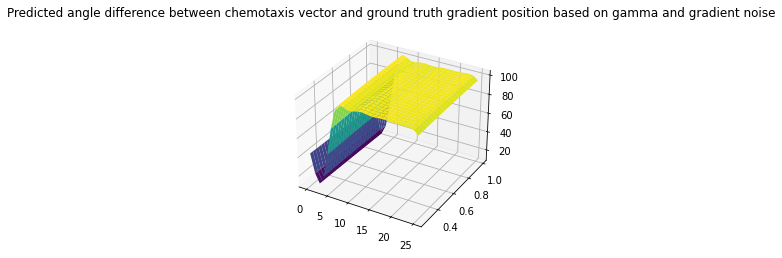

In [37]:
_gamma_test = np.linspace(0, 25, 25)
_gradnoise_test = np.linspace(0.25, 0.99, 25)

coords_gamma, coords_gradnoise = np.meshgrid(_gamma_test, _gradnoise_test)

_mean, _var = model_emukit.predict(np.c_[coords_gamma.ravel(), coords_gradnoise.ravel()])

reshaped_mean = _mean.reshape(coords_gamma.shape)


ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Predicted angle difference between chemotaxis vector and ground truth gradient position based on gamma and gradient noise')
# ax.scatter(model_emukit.X[0][0], model_emukit.X[0][1], model_emukit.Y[0], color='red', s=300, marker='x')

In [38]:
get_sobol_indices(model_emukit,parameter_space)

({'gamma': array([1.00075311]), 'gradnoise': array([-0.05217848])},
 {'gamma': array([1.05201909]), 'gradnoise': array([0.07211838])})

From this it's clear that the gamma parameter dominates over the grad noise parameter, and that low values of gamma are responsible for cells tending to form less blobs. 

# 4. Run Bayesian Optimization to find Environmental Parameters

In [110]:
def is_running():
    string='ps -e | grep "cell_evolution"'
    result=subprocess.getoutput(string)
    return len(result)>5


In [111]:
def f(X,negate=False):
    identifier = num_data_points+1
    for i in range(X.shape[0]):
        new_parameters = deepcopy(const_parameters)
        
        for j,name in enumerate(parameter_list):
            new_parameters[name] = data_types[name](X[i][j])
            
        identifier = identifier+i
        config_file = "latin_{}.par".format(identifier)
        
        create_config(config_file,new_parameters)
        execute_experiment(config_file,identifier)
        multiplier = 1
        
        if negate:
            multiplier - 1
            
    while check_is_running():
        time.sleep(20)
    
        
    Y = get_rewards(["data_cellcount_{}.txt".format(i) for i in range(identifier,identifier+X.shape[0])],lambda s: multiplier*average_function_over_time(num_blobs_cells)(s))
    
    return Y

In [112]:
data_types = {
    'season_duration': int,
    'T': float, 
    'gamma': int, 
    'gradnoise': float, 
    'target_area': int, 
    'mut_rate': float, 
}

In [113]:
const_parameters = {
    'mcs': 1000, 
    'gamma': 4, 
    'gradnoise': 0.9, 
    'target_area': 50, 
    'mut_rate': 0,
}

In [114]:
parameter_list = ['season_duration','T']
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,25))), 
                                 ContinuousParameter('T',1,100)])

In [45]:
num_data_points = 5
run_simulation_latin(parameter_space,num_data_points,0,const_parameters)

array([[550. ,  10.9],
       [200. ,  70.3],
       [725. ,  30.7],
       [900. ,  90.1],
       [375. ,  50.5]])

In [115]:
file_names = ["latin_{}.par".format(i) for i in range(num_data_points)]
data_files = ["data_cellcount_{}.txt".format(i) for i in range(num_data_points)]

In [117]:
X = get_parameter_array(file_names,parameter_list)
# Find the minimum instead
Y = get_rewards(data_files,lambda s: average_function_over_time(num_blobs_cells)(s))

In [118]:
model_gpy = GPRegression(X,Y) # Train and wrap the model in Emukit
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [119]:
expected_improvement = ExpectedImprovement(model = model_emukit)

In [120]:
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = expected_improvement,
                                         batch_size = 4)

In [121]:
max_iterations = 40
bayesopt_loop.run_loop(lambda x: f(x,negate=False), max_iterations)

 /home/nraman1/.local/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nraman1/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_22956/2893743866.py", line 2, in <module>
    bayesopt_loop.run_loop(lambda x: f(x,negate=False), max_iterations)
  File "/home/nraman1/.local/lib/python3.8/site-packages/emukit/core/loop/outer_loop.py", line 101, in run_loop
    new_x = self.candidate_point_calculator.compute_next_points(self.loop_state, context)
  File "/home/nraman1/.local/lib/python3.8/site-packages/emukit/bayesian_optimization/local_penalization_calculator.py", line 71, in compute_next_points
    local_penalization_acquisition = IntegratedHyperParameterAcquisition(self.model, LocalPenalization)
  File "/home/nraman1/.local/lib/python3.8/site-packages/emukit/core/acquisition/integrated_acquisition.py", line 41, in __init__
    self.update_parameters()
  File "/home/nraman1/.local/lib/python3.


KeyboardInterrupt



In [122]:
results = bayesopt_loop.get_results()
results

In [123]:
model_emukit.optimize()

In [124]:
results.minimum_location 

array([100., 100.])

In [125]:
results.minimum_value

2.0

In [126]:
model_emukit.X

ObsAr([[ 550.        ,   10.9       ],
       [ 200.        ,   70.3       ],
       [ 725.        ,   30.7       ],
       [ 900.        ,   90.1       ],
       [ 375.        ,   50.5       ],
       [1000.        ,    9.61553511],
       [1000.        ,    9.81350371],
       [1000.        ,   15.60848868],
       [1000.        ,   13.16457641],
       [ 100.        ,  100.        ],
       [ 100.        ,  100.        ],
       [ 100.        ,  100.        ],
       [ 100.        ,  100.        ],
       [ 100.        ,    2.45800214],
       [ 100.        ,    1.02664903],
       [ 100.        ,    5.51782771],
       [ 100.        ,    1.31463854],
       [1000.        ,   97.93236266],
       [1000.        ,   93.22466123],
       [1000.        ,   99.37415969],
       [1000.        ,   93.8426913 ],
       [ 100.        ,   98.2168622 ],
       [ 100.        ,   97.39665163],
       [ 100.        ,   98.76238955],
       [ 100.        ,   94.43746357],
       [1000.        ,   

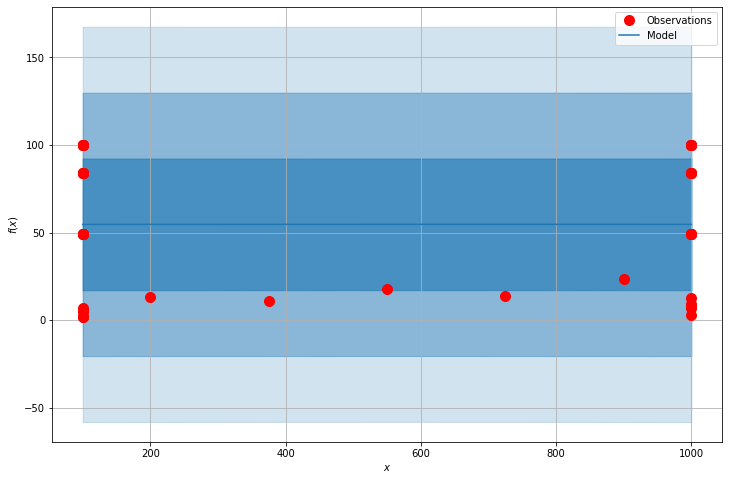

In [127]:
plot_gaussian_process(np.linspace(100,1000,25),0,parameter_space,model_emukit)

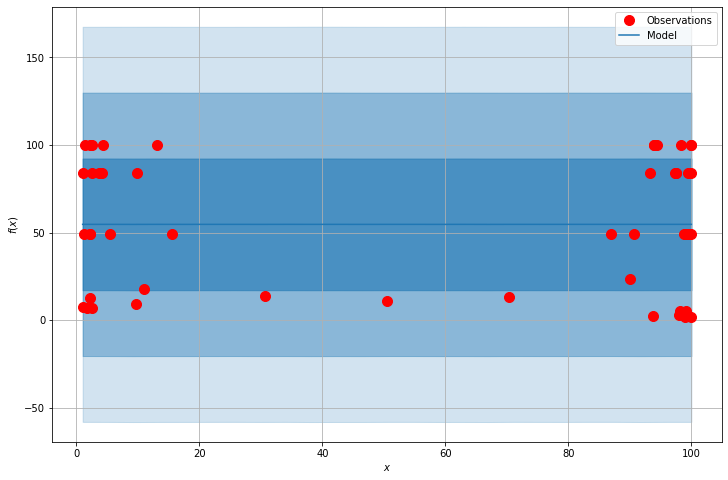

In [128]:
plot_gaussian_process(np.linspace(1,100,25),1,parameter_space,model_emukit)

Text(0.5, 0.92, 'Predicted angle difference between chemotaxis vector and ground truth gradient position based on gamma and gradient noise')

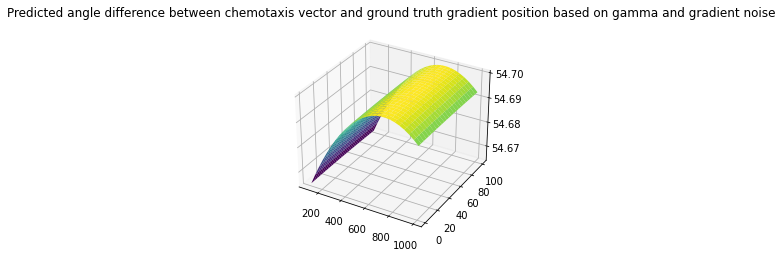

In [129]:

_gamma_test = np.linspace(100,1000,25)
_gradnoise_test = np.linspace(1,100,25)

coords_gamma, coords_gradnoise = np.meshgrid(_gamma_test, _gradnoise_test)

_mean, _var = model_emukit.predict(np.c_[coords_gamma.ravel(), coords_gradnoise.ravel()])

reshaped_mean = _mean.reshape(coords_gamma.shape)


ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Predicted angle difference between chemotaxis vector and ground truth gradient position based on gamma and gradient noise')
# ax.scatter(model_emukit.X[0][0], model_emukit.X[0][1], model_emukit.Y[0], color='red', s=300, marker='x')

In [ ]:
max_iterations = 2
bayesopt_loop.run_loop(lambda x: f(x,negate=True), max_iterations)

In [ ]:
results = bayesopt_loop.get_results()
results

In [ ]:
results.minimum_location 

In [ ]:
results.minimum_value

# 5. Run Bayesian Optimization to find Cell-based Parameters


In [ ]:
const_parameters = {
    'mcs': 10*1000, 
    'gamma': 4, 
    'gradnoise': 0.9, 
    'target_area': 50, 
    'mut_rate': 0,
    'T': 
}

In [75]:
import os

23288 ?        00:02:51 cell_evolution
23292 ?        00:02:50 cell_evolution
